# Hospital Operations Efficiency & Resource Utilization

This notebook will serve as a framework for the predictive efficiency model — it won’t train a model yet, but it will contain a complete, well-documented, modular structure ready for data connection and modeling.

**Author:** Aman Kumar Singh

---

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Display settings
pd.set_option("display.max_columns", None)
plt.style.use("ggplot")

## 2. Database Connection

In [2]:
server = 'localhost'
database = 'HospitalOpsDB'
connection_string = (
    "Driver={ODBC Driver 17 for SQL Server};"
    f"Server={server};"
    f"Database={database};"
    "Trusted_Connection=yes;"
)

conn = pyodbc.connect(connection_string)
print("✅ Connected successfully!")

✅ Connected successfully!


## 3. Data Extraction

In [3]:
query = """
SELECT TOP 5000
    h.HospitalID,
    h.Region,
    d.DeptID,
    d.Capacity,
    ru.BedOccupancyRate,
    ru.EquipmentUtilizationRate,
    ru.StaffUtilizationRate,
    f.TotalCost,
    f.BilledAmount,
    f.ProfitMargin,
    f.InsuranceCoveragePct,
    a.LengthOfStay,
    a.ReadmissionFlag
FROM ResourceUtilizationSnapshots ru
JOIN Departments d ON ru.DeptID = d.DeptID
JOIN Hospitals h ON ru.HospitalID = h.HospitalID
JOIN Financials f ON ru.HospitalID = f.HospitalID AND ru.DeptID = f.DeptID
JOIN Admissions a ON a.HospitalID = h.HospitalID AND a.DeptID = d.DeptID
WHERE ru.SnapshotDate >= '2024-01-01'
"""
df = pd.read_sql(query, conn)
conn.close()

print("✅ Data Loaded Successfully!")
display(df.head())

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12828\3704134663.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


✅ Data Loaded Successfully!


,HospitalID,Region,DeptID,Capacity,BedOccupancyRate,EquipmentUtilizationRate,StaffUtilizationRate,TotalCost,BilledAmount,ProfitMargin,InsuranceCoveragePct,LengthOfStay,ReadmissionFlag
0,5,Central,35,13,0.46,0.2,0.39,654805.98,938611.87,0.3,0.73,6,0
1,5,Central,35,13,0.46,0.2,0.39,654805.98,938611.87,0.3,0.73,4,0
2,5,Central,35,13,0.46,0.2,0.39,654805.98,938611.87,0.3,0.73,4,0
3,5,Central,35,13,0.46,0.2,0.39,654805.98,938611.87,0.3,0.73,3,0
4,5,Central,35,13,0.46,0.2,0.39,654805.98,938611.87,0.3,0.73,4,0


## 4. Data Preparation

In [4]:
# Drop duplicates
df = df.drop_duplicates()

# Handle missing values
df = df.fillna(df.median(numeric_only=True))

# Encode categorical variables
df = pd.get_dummies(df, columns=["Region"], drop_first=True)

# Feature engineering: create Efficiency Score
df["EfficiencyScore"] = (
    0.4 * df["BedOccupancyRate"]
    + 0.3 * df["EquipmentUtilizationRate"]
    + 0.3 * df["StaffUtilizationRate"]
)

## 5. Define Features and Target

In [ ]:
X = df[[
    "Capacity", "BedOccupancyRate", "EquipmentUtilizationRate",
    "StaffUtilizationRate", "TotalCost", "BilledAmount",
    "InsuranceCoveragePct", "LengthOfStay", "ReadmissionFlag"
] + [col for col in df.columns if "Region_" in col]]

y = df["ProfitMargin"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_feature_names = list(X_train.columns)
print("Number of training features:", len(train_feature_names))
print("Training feature names (first 40):", train_feature_names[:40])

Number of training features: 9
Training feature names (first 40): ['Capacity', 'BedOccupancyRate', 'EquipmentUtilizationRate', 'StaffUtilizationRate', 'TotalCost', 'BilledAmount', 'InsuranceCoveragePct', 'LengthOfStay', 'ReadmissionFlag']


## 6. Model Training & Comparison

In [6]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse})

results_df = pd.DataFrame(results)
display(results_df)

,Model,R2,MAE,RMSE
0,Linear Regression,0.937656,2.242178e-02,2.856355e-02
1,Random Forest,1.000000,3.663736e-16,4.793766e-16


## 7. Feature Importance (Random Forest)

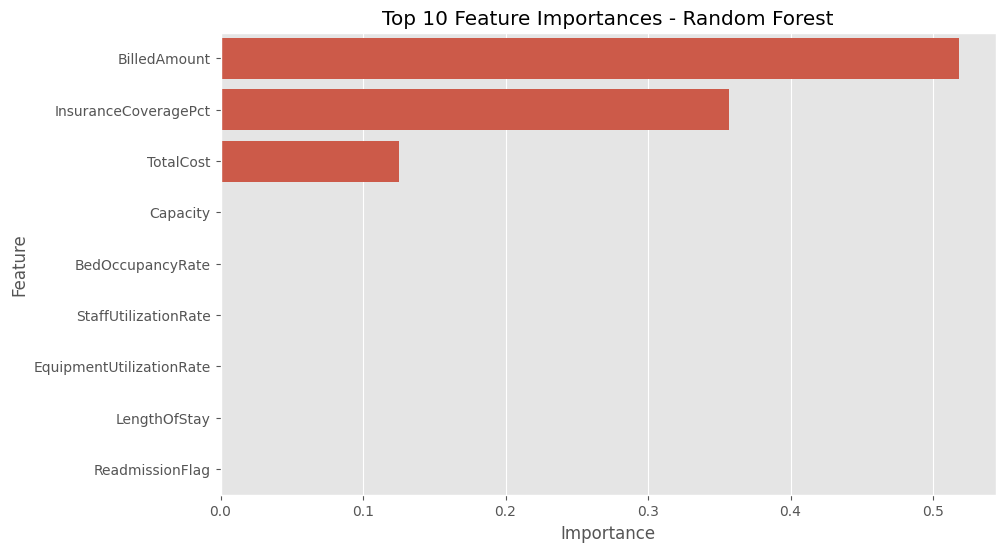

In [7]:
rf_model = models["Random Forest"]
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(10))
plt.title("Top 10 Feature Importances - Random Forest")
plt.show()

## 8. Predictive Efficiency Scenario (Placeholder)

In [11]:
raw_sample = pd.DataFrame({
    "Capacity": [100],
    "BedOccupancyRate": [0.80],
    "EquipmentUtilizationRate": [0.75],
    "StaffUtilizationRate": [0.70],
    "TotalCost": [1000000],
    "BilledAmount": [1200000],
    "InsuranceCoveragePct": [0.60],
    "LengthOfStay": [5],
    "ReadmissionFlag": [0],
    "Region": ["North"]
})

if 'Region' in X_train.columns or any(col.startswith('Region_') for col in X_train.columns):
    region_dummies = pd.get_dummies(raw_sample['Region'], prefix='Region')
    raw_sample = raw_sample.drop(columns=['Region'], errors='ignore')
    sample_proc = pd.concat([raw_sample.reset_index(drop=True), region_dummies.reset_index(drop=True)], axis=1)
else:
    sample_proc = raw_sample.copy()
missing_cols = [c for c in train_feature_names if c not in sample_proc.columns]
extra_cols   = [c for c in sample_proc.columns if c not in train_feature_names]
for c in missing_cols:
    sample_proc[c] = 0
if extra_cols:
    sample_proc = sample_proc.drop(columns=extra_cols)
sample_proc = sample_proc[train_feature_names]
if sample_proc.isna().any().any():
    sample_proc = sample_proc.fillna(0)
sample_scaled = scaler.transform(sample_proc) 
predicted_profit = rf_model.predict(sample_scaled)[0]

print("Sample (aligned) features:")
display(sample_proc.head(1))
print(f"📈 Predicted Profit Margin (decimal): {predicted_profit:.4f}")
print(f"📈 Predicted Profit Margin (percentage): {predicted_profit*100:.2f}%")
# ---------------------------------------------------------------

Sample (aligned) features:


,Capacity,BedOccupancyRate,EquipmentUtilizationRate,StaffUtilizationRate,TotalCost,BilledAmount,InsuranceCoveragePct,LengthOfStay,ReadmissionFlag
0,100,0.8,0.75,0.7,1000000,1200000,0.6,5,0


📈 Predicted Profit Margin (decimal): 0.3300
📈 Predicted Profit Margin (percentage): 33.00%


## 9. Save Outputs

In [15]:
import os

# ensure the reports folder exists (relative to notebook)
os.makedirs("../reports", exist_ok=True)

# now safely write the CSVs
results_df.to_csv("../reports/predictive_model_results.csv", index=False)
importance_df.to_csv("../reports/feature_importance.csv", index=False)

print("✅ Modeling complete. Reports saved to /reports/")

✅ Modeling complete. Reports saved to /reports/
